# Dynamic instability in Self-assembly

## Preview of Updation
- Issue 1

Last we week found that: when trying to attatch a tile to an empty row, even it is bonded to its left tile, the chance of surviving is still much smaller the the detaching chance, which result in at beginning we attach a tile and then remove it.

- Solution 1

According to this article (http://self-assembly.net/wiki/index.php/Kinetic_Tile_Assembly_Model_(kTAM)), for the bondary tiles, we arbitarily set the boundary tile has 2 bonds to the left tiles, so the assembly can grow. See the update in self._count_bounds() 

- Issue 2

when the last chain(row) is full of tiles, previous version we directly attach it to the rest assembly, which result in a high error rate for the lastest attached tile
- Solution 2

here we give some chance to check whether we should attach it according to current partition function -- either remove one tile of last chain; or attach the last chain and trying to add a new tile

- Minor points
    - Update the interaction matrices: I think for the barrier part we should use keep (i,j) instead of (i-1,j-1) since i=j=0 refers to the empty state
    - Update try_attach()/try_detach(), just to be consistent in grammar

## Issues
Now we can play with parameters
- p.30 SFig.2.2.c (ii)
    -- First I try to benchmark this plot and there is something I can't understand: why their error rate is so low? In principle, if one tile has two bonds, it is very likely to survive. Thus, despite the ordered chain 1-2-3-4-5-6, or the disordered example they've shown 1-5-4-3-2-6, there are still other possibilities like: 1-2-3-4-2-6 and 1-5-4-3-5-6 which still satisfy the 2-bonds-rule. So actually it's very likely to have errors...

- (if we have time) we need to vary the dynamic instability (t_melt) during the evolution, but I don't understand how they emplement this (they write it on p.29, the paragraph before 2.4.1, but I don't know what do they mean [The change was accepted if it increased the mean of the inverse of the times taken to reach the target size]

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from tqdm.notebook import tqdm_notebook
from matplotlib.colors import BoundaryNorm


# Customization of the figures parameters
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams["savefig.format"] = "png"
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["figure.figsize"] = (12.8, 7.2)

In [38]:
class Assembly:
    """
    Class for representing the assembmly.

    It is represented as an array of size (6, N), accessible with self.chain.
    The elements are integers from 0 to 12, where 0 means empty, and 1 to 12 a tile of corresponding number.
    """

    # TODO: add the possibility to add only one tile, and keep track of empty in last line.
    # Idea for that: check nb of bonds on each of the 6 accessible sites, attach at random, with higher proba if more bonds.
    def __init__(self, cross, nonSpec):
        """
        Creates the assembly, and the interaction matrix.

        cross: gives which interactions are taken into account. See p40.
               0, 1, 2 correspond to the small, medium, large barrier respectively.
               
        nonSpec: consider the nonsecific interations or not.

        """
        if cross not in (0, 1, 2):
            raise ValueError(f"The parameter must be equal to 0, 1 or 2 (and not {cross}).")

        J_NS = np.zeros((13, 13))  # Construction of interaction martix, north-south
        J_WE = np.zeros((13, 13))  # Construction of interaction martix, western-east
        for i in range(13):
            for j in range(13):
                # Interactions for all barriers
                if j == 0 or i == 0:  # 0 means empty, so it does not interact with anything
                    continue
                if j == i+1:
                    J_NS[i, j] = 1
#                     J_NS[j, i] = 1  # Makes the matrix symmetric

                elif nonSpec == True and (i, j) in [(1, 5), (5, 4), (4, 3), (3, 2), (2, 6)]: 
                    J_NS[i, j] = 1
                
                elif j == i+6:  # The paper indicates i+5, but I think it is i+6 (e.g. 2 should link with 8, and not 7).
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1

                # Interactions that depend on the barrier
                if nonSpec == True and cross == 0 and (i, j) in [(5, 8), (4, 9)]:
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1
                elif nonSpec == True and cross == 1 and (i, j) in [(5, 8), (3, 10)]:
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1

        self.chain = np.array([[1, 2, 3, 4, 5, 6]], dtype=int)  
        self.chain = np.block([[self.chain],[7,8,9,10,11,12]]) #initialzie the assembly as two rows (1-2-3-4-5/7-8-9-10-11-12)
        self.lastchain = np.zeros(6, dtype = int) # initialize the last chain
        self.inter_NS = J_NS  # Interaction matrix, north-south
        self.inter_WE = J_WE  # Interaction matrix, west-east

    def add_line(self, line):
        """
        Adds a new line to the assembly.

        The inputs are the assembly, and an array or a list of size 6 to append to the assembly.
        """
        line = np.array(line, dtype=int)
        # Checks that the new line has the right format
        if not all([elem >= 0 and elem <= 12 for elem in line]):
            raise ValueError(f"Invalid elements in added line: {line}.")
        if len(line) != 6:
            raise ValueError(f"The added line {line} must be of length 6 (and not {len(line)}).")

        self.chain = np.block([[self.chain], [line]])

    def remove_line(self):
        """Removes the last line of the assembly."""
        self.chain = self.chain[:-1, :]

    def energy(self):
        """Returns the energy of the assembly."""
        e = 0
        a, b = self.chain.shape

        # This adds 0 below and on the right of the assembly matrix.
        # They will give no interaction with the rest of the assembly
        # but allow to handle the boundaries more easily
        low = np.zeros(a+1, dtype=int)
        right = np.zeros(b, dtype=int)
        A2 = np.block([[self.chain], [right]])
        A = np.column_stack([A2, low])

        # Computation of the energy
        for i in range(a):  # Loops on the shape of the original assembly
            for j in range(b):
                # A has a shape of a+1, b+1, so no out-of-index errors
                val = A[i, j]  # Type of the block at i, j
                val_b = A[i, j+1]  # Value of the block below (or to the right in the article's figures)
                val_r = A[i+1, j]  # Value right (or below in the figure)
                e += self.inter_WE[val, val_r]  # Interaction on the right
                e += self.inter_NS[val, val_b]  # Interaction below
        return e
    
    def evolve_new(self, Nstep, Gmc, Gse, kf, cycles=None):
        """
        Simulates the growth of an assembly using the kTAM model.

        Nstep: Number of steps (attachment or detachment)
        Gmc: Free energy for monomer concentration (controls attachment rate)
        Gse: Free energy of binding for each bond (controls detachment rate) in grow, melt states
        kf: Frequency factor for attachment and detachment rates
        cycles: Melting time, cycle time (in steps). If None, melting time is 0

        Returns:
            - The energy at each step
            - A record of the assembly states at each step for visualization
        """
        E = np.zeros(Nstep)  # Energy at each step
        assembly_snapshots = []  # Store snapshots of the assembly for visualization later
        if cycles is None:  # Same syntax as before if cycles are not studied.
            cycles = (0, 3600)
            Gse = (Gse, Gse)
            
        pbar = tqdm_notebook(np.arange(Nstep))  # to show the interation time
        for n, step in enumerate(pbar):
            if n % cycles[1] <= cycles[0]:  # Melting state: weak bonds
                Gse_step = Gse[1]
            else:  # Growing state: strong bonds
                Gse_step = Gse[0]
                
            occupied_positions = np.argwhere(self.lastchain != 0)
            empty_positions = np.argwhere(self.lastchain == 0)
            
            if len(occupied_positions) == 0: # if it's empty go for detaching the previous one; or try to attach a new
                if np.random.rand() < 0.5:
                    self.lastchain = self.chain[-1, :].reshape(-1)
                    self.remove_line()
                else:
                    self.try_attach()
                    
            elif len(occupied_positions) == 6: # give some chance to check the last chain before attaching
                
                Z = 0
                p = [] # caculate np.exp(-bonds * Gse_step)                    
                for occupied_index in occupied_positions:
                    tile_now = self.lastchain[occupied_index]
                    bond_now = self._count_bonds(occupied_index, tile_now)
                    p.append(np.exp(-bond_now * Gse_step))
                    Z += np.exp(-bond_now * Gse_step)
                
                Z += 6 * np.exp(-Gmc)
                pro_add = 6 * np.exp(-Gmc) / Z
                
                if np.random.rand() < pro_add: # we should attach the whole chain
                    self.add_line(self.lastchain)
                    self.lastchain = np.zeros(6, dtype=int)
                else: # remove a tile
                    self.try_detach(p)
                    
            else:   #compute the partition function    
                Z = 0
                p = [] # caculate np.exp(-bonds * Gse_step)                    
                for occupied_index in occupied_positions:
                    tile_now = self.lastchain[occupied_index]
                    bond_now = self._count_bonds(occupied_index, tile_now)
                    p.append(np.exp(-bond_now * Gse_step))
                    Z += np.exp(-bond_now * Gse_step)

                Z += len(empty_positions) * np.exp(-Gmc)
                pro_add = len(empty_positions) * np.exp(-Gmc) / Z 

                if np.random.rand() < pro_add: # we should a add tile
                    self.try_attach()
                else: # remove a tile
                    self.try_detach(p)
            
            E[n] = self.energy()  # Recompute energy after each step
            if n % 100 == 0:  # Store one snapshot every 100 steps to not take too much resources ?
                assembly_snapshots.append(self.chain.copy())  # Save the assembly state

        return E, assembly_snapshots

    
    def try_attach(self):
        """
        Attempt to attach a tile at a random empty position in the assembly.
        """
        
        empty_positions = np.argwhere(self.lastchain == 0)

        if len(empty_positions) == 0:
            return  # No empty positions to attach a tile

        # Randomly pick an empty position
        i = empty_positions[np.random.randint(len(empty_positions))]

        # Try attaching a random tile (between 1 and 12)
        tile = np.random.randint(1, 13)
        self.lastchain[i] = tile  # Attach the tile
        
    def try_detach(self,p):
        """
        Attempt to detach a tile at a random empty position in the assembly.
        input: p, the partition function of the possible detach sites
        """
        occupied_positions = np.argwhere(self.lastchain != 0)
        seed_now = np.random.rand()
        p = np.array(p) / np.sum(p)
        for j,occupied_index in enumerate(occupied_positions):
            if(seed_now < np.sum(p[:(j+1)])):
                self.lastchain[occupied_index] = 0
                break

    def _count_bonds(self, i, tile):
        """
        Count the number of bonds a tile at position i would form with its neighbors.
        """
        bonds = 0
        
#         if len(self.chain)<1: #if only one last chain exits,we don't want it to melt, so set the bond to 2
#             return 2
        
        if i == 0:
            neighbors_tile_NS_Down = self.lastchain[i+1] # Bottom neibors
            neighbor_tile_WE = self.chain[-1,i] #Check the left neighbor
            bonds += self.inter_NS[tile,neighbors_tile_NS_Down]
            bonds += 2 * self.inter_WE[neighbor_tile_WE,tile]  # 2 for the boundary tile
        elif i == 5:
            neighbors_tile_NS_Up = self.lastchain[i-1]  # Top neighbors
            neighbor_tile_WE = self.chain[-1,i] #Check the left neighbor
            bonds += self.inter_NS[neighbors_tile_NS_Up,tile]
            bonds += 2 * self.inter_WE[neighbor_tile_WE,tile]  # 2 for the boundary tile
            
        else:
            neighbors_tile_NS_Up = self.lastchain[i-1]  # Top neighbors
            bonds += self.inter_NS[neighbors_tile_NS_Up,tile]
            neighbors_tile_NS_Down = self.lastchain[i+1] # Bottom neibors
            bonds += self.inter_NS[tile,neighbors_tile_NS_Down]
            neighbor_tile_WE = self.chain[-1,i] #Check the left neighbor
            bonds += self.inter_WE[neighbor_tile_WE,tile]  # Add interaction if there's a bond
                
        return bonds

    def disorder(self,chain):
        """Returns the proportion of disordered rows."""
        count = 0
        for line in chain:
            if (any(line != np.array([1, 2, 3, 4, 5, 6], dtype=int))
                    and any(line != np.array([7, 8, 9, 10, 11, 12], dtype=int))):
                count += 1
        return count/len(chain)


In [39]:
def plot_energy(Nstep, cross, nonSpec, Gmc, Gse, kf):
    """Plot the energy as a function of the step."""
    A = Assembly(cross, nonSpec)
    E,_ = A.evolve(Nstep, Gmc, Gse, kf)
    fig, ax = plt.subplots()
    ax.plot(E)
    ax.set(title="Energy of the assembly", xlabel="Step", ylabel="Energy")
    plt.show()

def plot_assembly(Nstep, cross, nonSpec, Gmc, Gse, kf):
    """Plot the assembly with a colormap."""
    A = Assembly(cross, nonSpec)
    A.evolve(Nstep, Gmc, Gse, kf)
    print(A.chain)

    cmap = mpl.colormaps.get_cmap("viridis")
    cmap.set_under("w")  # Sets the 0 values to white color.
    ticks = np.arange(1, 13)  # Renormalize to [1, 12], so 0 are below the min
    norm = BoundaryNorm(ticks, cmap.N)  # Renormalize and discretize the colormap
    fig, ax = plt.subplots()
    img = ax.pcolor(A.chain.T, cmap=cmap, norm=norm)  # Transposed, so that it is plotted like in the paper.
    fig.colorbar(img, ticks=ticks, norm=norm)
    ax.set(title="Assembly", xlabel="Line", ylabel="Column")
    plt.show()

## First Try

  0%|          | 0/30000 [00:00<?, ?it/s]

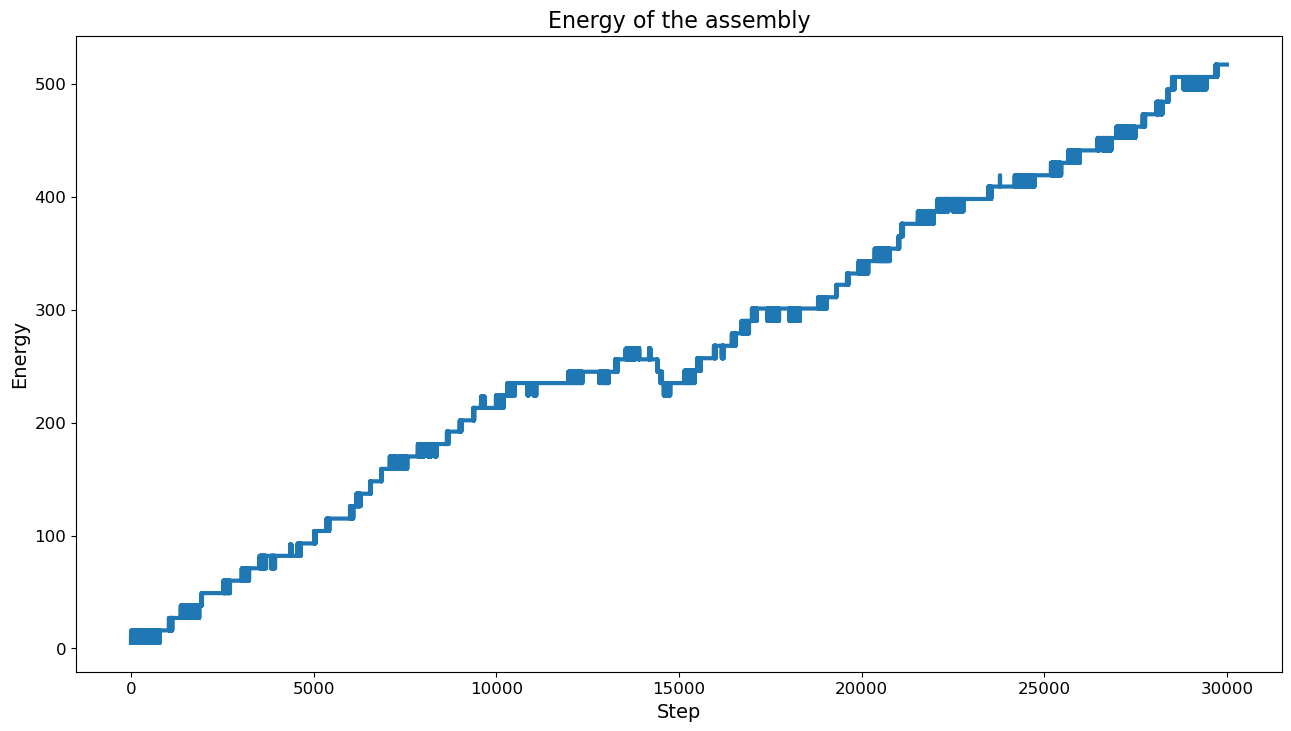

In [34]:
Nstep=30000
cross=0 # 2 for high barrier; 1 for medium; 0 for small
nonSpec=True #False for specific interations, which should return ordered structures
Gmc=16
Gse=(9.5, 8.4)
kf=7*10**6
cycles=(300, 3600)

A = Assembly(cross, nonSpec)
E,snapshots = A.evolve_new(Nstep, Gmc, Gse, kf, cycles)
fig, ax = plt.subplots()
ax.plot(E)
ax.set(title="Energy of the assembly", xlabel="Step", ylabel="Energy")
plt.show()

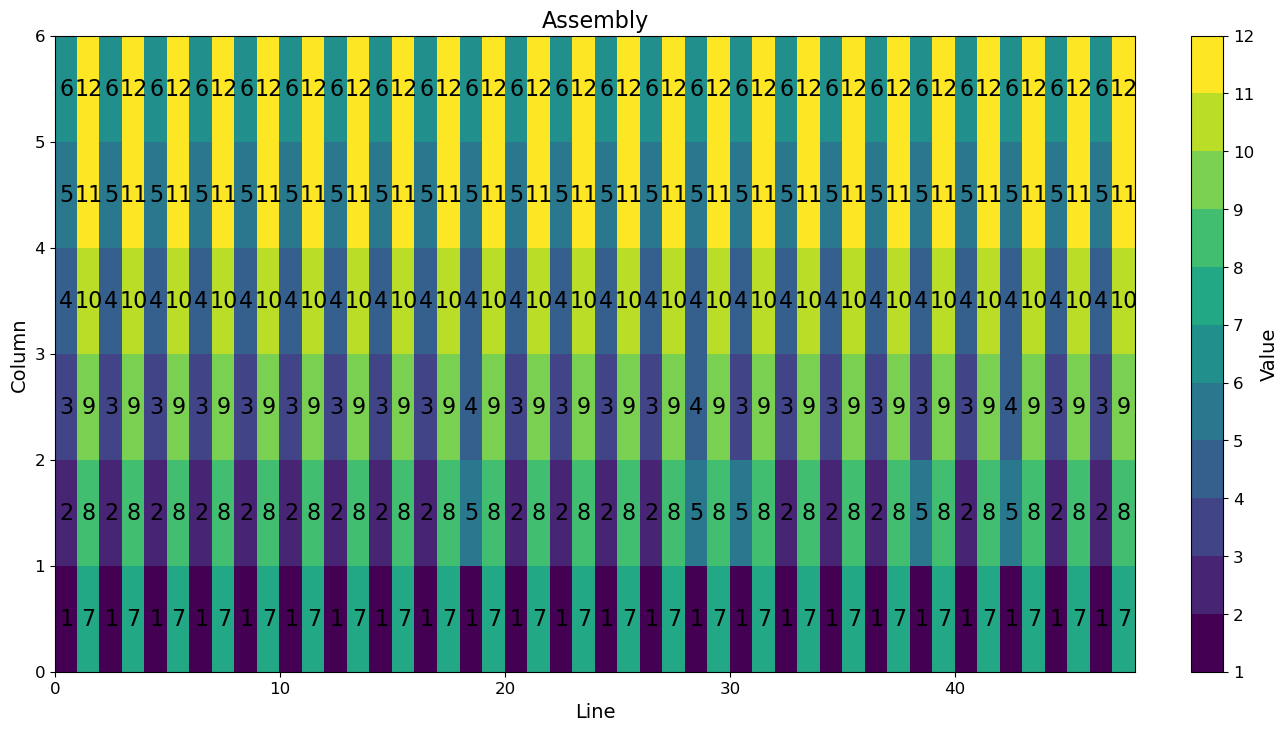

In [35]:
# Set up the colormap and normalization
cmap = mpl.colormaps.get_cmap("viridis")
cmap.set_under("w")  # Sets the 0 values to white color.
ticks = np.arange(1, 13)  # Renormalize to [1, 12], so 0 are below the min
norm = BoundaryNorm(ticks, cmap.N)  # Renormalize and discretize the colormap

# Create the figure and axis
fig, ax = plt.subplots()

# Create the pcolor plot
frame = -1
img = ax.pcolor(snapshots[frame].T, cmap=cmap, norm=norm)  # Transposed for correct orientation

# Add the colorbar
cbar = fig.colorbar(img, ticks=ticks, norm=norm)
cbar.set_label('Value')  # Optional label for the colorbar

# Annotate each cell with its value
for (i, j), value in np.ndenumerate(snapshots[frame].T):
    ax.text(j + 0.5, i + 0.5, f'{value}', ha='center', va='center', color='black')

# Set titles and labels
ax.set(title="Assembly", xlabel="Line", ylabel="Column")

# Show the plot
plt.show()

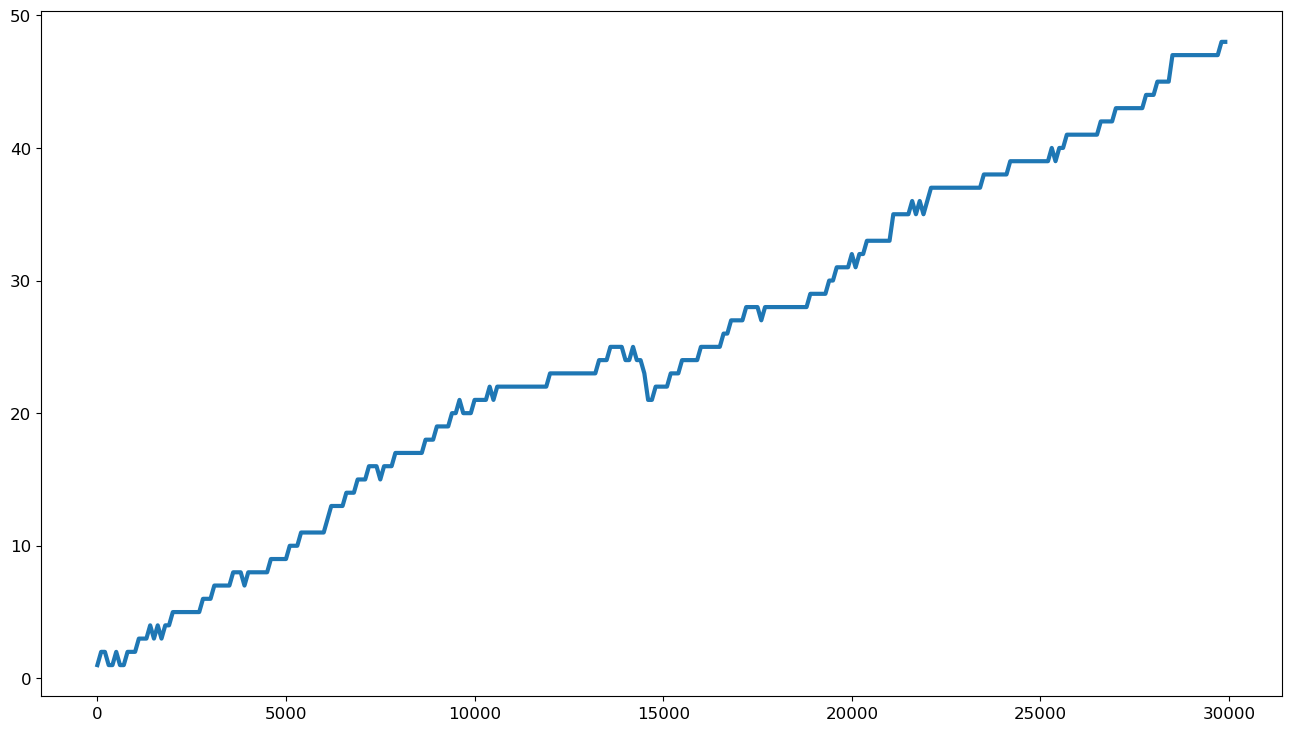

In [36]:
#number of rows through evolutions
num_tile = []
for i, row in enumerate(snapshots):
    num_tile.append(len(row))
    
fig, ax = plt.subplots()
ax.plot(np.arange(0,Nstep,100),num_tile)

(0.001, 1)

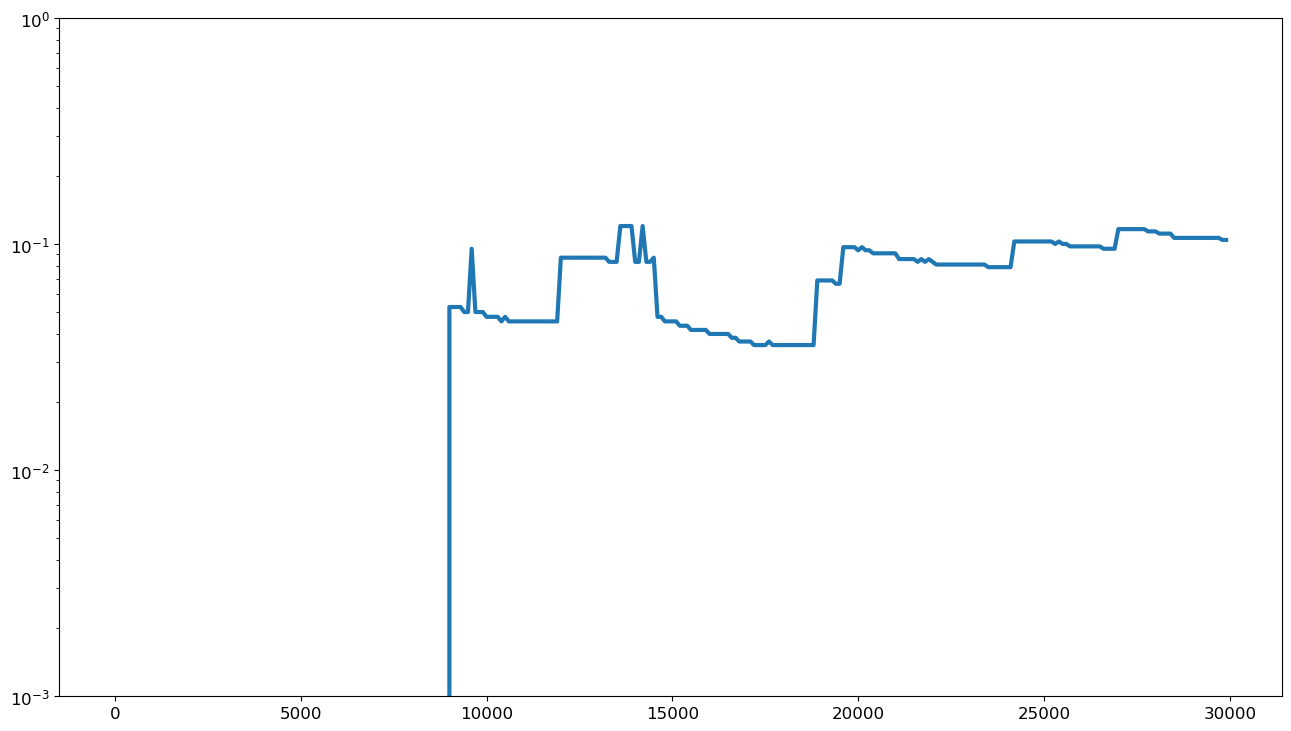

In [37]:
# fraction of error trains through evolution
disorder = []

for i, snapshot in enumerate(snapshots):
    disorder.append(A.disorder(snapshot))
    
fig, ax = plt.subplots()
ax.plot(np.arange(0,Nstep,100),disorder)
ax.set_yscale('log')
ax.set_ylim(10**(-3),1)